In [236]:
inpfile = 'shop1_v3.csv'
df = pd.read_csv(inpfile,encoding='latin1')

In [237]:
from xgboost import XGBRegressor

In [238]:
df.columns

Index(['month_idx', 'hour_idx', 'mday_idx', 'year_idx', 'temperature',
       'precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'wday', 'month', 'hour', 'mday',
       'year', 'timestamp', 'month.1', 'hour.1', 'mday.1', 'year.1',
       'is_resto', 'price', 'count', 'n_transactions', 'last_week_price',
       'last_month_price'],
      dtype='object')

In [239]:
features = ['precipitation', 'snowfraction', 'sealevelpressure', 'winddirection',
       'windspeed', 'relativehumidity', 'sunshinetime', 'totalcloudcover',
       'lowclouds', 'midclouds', 'highclouds', 'last_week_price','last_month_price', 
            # 'is_resto'
           ] 

df[features] = df[features].fillna(0.)
features += [ 
         'month', 'mday', 'hour', 'wday'] 
X = df[ features ]

#target = 'price'
#target = 'n_transactions'
target = 'count'

y = df[target]

In [240]:
# df.shape

In [241]:
%matplotlib inline
df[(df.year == 2018) & (df.month == 1)].mday.unique()


array([19.,  1.,  2.,  4.,  6.,  7., 13., 14., 18., 20., 21., 24.,  3.,
        5.,  8.,  9., 10., 11., 12., 15., 16., 17., 22., 23.])

In [242]:
test_sel = (df.year == 2018) & (df.month == 1) & (df.mday >=13) & (df.mday <20)

df[test_sel]

,month_idx,hour_idx,mday_idx,year_idx,temperature,precipitation,snowfraction,sealevelpressure,winddirection,windspeed,...,month.1,hour.1,mday.1,year.1,is_resto,price,count,n_transactions,last_week_price,last_month_price
0,1,0,19,2018,5.72,0.7,0.0,1008.3,259.0,11.49,...,1.0,0.0,19.0,2018.0,0.000000,39.40,4.00,1,37493.50,37493.50
6,1,9,13,2018,0.71,0.0,0.0,1023.7,59.0,3.14,...,1.0,9.0,13.0,2018.0,0.761905,1427.80,43.37,17,33299.15,33299.15
7,1,9,14,2018,NaN,0.0,0.0,1022.0,28.0,1.70,...,1.0,9.0,14.0,2018.0,1.000000,1883.30,106.26,10,37431.40,37431.40
8,1,9,18,2018,4.60,0.0,0.0,1010.2,247.0,16.12,...,1.0,9.0,18.0,2018.0,0.400000,32.95,6.61,3,35213.05,35213.05
24,1,10,13,2018,1.85,0.0,0.0,1023.1,52.0,2.78,...,1.0,10.0,13.0,2018.0,0.636364,885.40,94.88,28,33060.65,33060.65
25,1,10,14,2018,1.56,0.0,0.0,1021.8,23.0,1.30,...,1.0,10.0,14.0,2018.0,0.824561,1295.70,109.47,28,37945.45,37945.45
26,1,10,15,2018,4.06,0.0,0.0,1019.3,211.0,2.69,...,1.0,10.0,15.0,2018.0,0.666667,133.75,31.76,13,38248.60,38248.60
27,1,10,16,2018,7.58,0.2,0.0,1001.2,250.0,12.91,...,1.0,10.0,16.0,2018.0,0.625000,69.60,17.68,8,32431.65,32431.65
28,1,10,17,2018,2.01,0.0,0.0,1005.7,288.0,12.84,...,1.0,10.0,17.0,2018.0,0.777778,31.20,9.47,5,31736.20,31736.20
29,1,10,18,2018,5.58,0.0,0.0,1009.7,248.0,15.93,...,1.0,10.0,18.0,2018.0,0.400000,124.00,26.66,10,35368.65,35368.65


In [243]:
reg  = XGBRegressor(max_depth=20,n_estimators=300,reg_lambda=0.5,subsample=0.6, base_score=y.mean(), random_state=1234)



In [244]:
from sklearn.model_selection import train_test_split

In [245]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=2354)

# scores = []
# for iseed in range(10):
#     np.random.seed(iseed)
#     X_train, X_test, y_train, y_test = train_test_split(X,y)
    
#     reg.fit(X_train,y_train)

#     scores.append(reg.score(X_test,y_test))
    


In [246]:
# print(inpfile,np.array(scores).mean(),np.array(scores).std()) 

In [247]:
X_train = X[~test_sel]
X_test = X[test_sel]

y_train = y[~test_sel]
y_test = y[test_sel]

reg.fit(X_train,y_train)


XGBRegressor(base_score=134.47848767833983, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=1234, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [248]:
y_pred = reg.predict(X_test)

# from sklearn.metrics import r2_score

# r2_score(y_test,y_pred)

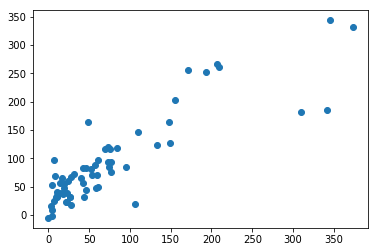

In [249]:
plt.scatter(y_test,y_pred)

In [250]:
list(zip(features, reg.feature_importances_))

[('precipitation', 0.052904323),
 ('snowfraction', 0.001663276),
 ('sealevelpressure', 0.24118851),
 ('winddirection', 0.16230942),
 ('windspeed', 0.12857832),
 ('relativehumidity', 0.08874741),
 ('sunshinetime', 0.03035057),
 ('totalcloudcover', 0.014088926),
 ('lowclouds', 0.013073417),
 ('midclouds', 0.017705623),
 ('highclouds', 0.027911324),
 ('last_week_price', 0.09351458),
 ('last_month_price', 0.0),
 ('month', 0.017317638),
 ('mday', 0.033268895),
 ('hour', 0.05585976),
 ('wday', 0.021518001)]

In [251]:
from sklearn.ensemble import GradientBoostingRegressor


In [252]:
qt025 = GradientBoostingRegressor(loss='quantile',alpha=0.25,subsample=0.8,max_depth=5)
qt075 = GradientBoostingRegressor(loss='quantile',alpha=0.75,subsample=0.8,max_depth=5)


In [253]:
qt025.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.25, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [254]:
qt075.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.75, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='quantile', max_depth=5,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)

In [255]:
y025_pred = qt025.predict(X_test)
y075_pred = qt075.predict(X_test)


In [256]:
print( (y_test < y025_pred).sum() / y_test.count() )
print( (y_test > y075_pred).sum() / y_test.count() )

0.36363636363636365
0.12121212121212122


In [257]:
df_test = df.loc[y_test.index]

In [258]:
from sklearn.preprocessing import OneHotEncoder

In [259]:
# bins = pd.get_dummies(df_test, columns=['month'])#.reshape((-1,12,1))

# print(bins.columns)
df_test['pred'] = y_pred
df_test['pred_min'] = y025_pred
df_test['pred_max'] = y075_pred
df_test['err'] = y_pred - y_test
df_test['err_min'] = y025_pred - y_test > 0.
df_test['err_max'] = y075_pred - y_test > 0.



In [260]:
# err = (y_pred - y_test).ravel()

# means = np.average( err*bins, weights=bins, axis=1 )

In [261]:
# # bins*err
# plt.plot(df_test.pred_min,df_test.pred_max)
import os
import pickle
from gzip import open as gopen


# outdir = inpfile.replace('.csv','')+"_"+target
outdir = inpfile.replace('.csv','')+"_dashb_"+target

if not os.path.exists(outdir):
    os.mkdir(outdir)
    

with gopen('%s/model.plk.gz' % outdir, 'w+') as gmod:
    gmod.write( pickle.dumps(reg) )
    
with gopen('%s/model025.plk.gz' % outdir, 'w+') as gmod:
    gmod.write( pickle.dumps(qt025) )

with gopen('%s/model075.plk.gz' % outdir, 'w+') as gmod:
    gmod.write( pickle.dumps(qt075) )


In [234]:
def prediction_profile(df,by,bins=None,range=None,label="",outdir=outdir,taget=target):
    
    xlabel = by
    outname = '%s/pred_%s' % (outdir, by)
    if label != "":
        outname += "_%s" % label
    if bins is not None:
        #probs = np.linspace(0,100,bins)
        #print(probs)
        #bins = np.percentile(df[by],probs)
        if range is None:
            range = df[by].min(),df[by].max()
        bins = np.linspace(*range,bins+1)
        labels = 0.5*(bins[1:]+bins[:-1])
        #print(bins)
        df[by+'_bins'] = pd.cut( df[by], bins, labels=labels ).astype(np.float)
        by = by+'_bins'
    
    meanpred = df.groupby(by)['pred'].mean()
    meanpred_min = df.groupby(by)['pred_min'].mean()
    meanpred_max = df.groupby(by)['pred_max'].mean()
    unc = 0.5*(meanpred_max-meanpred_min)
    meantrue = df.groupby(by)[target].mean()
    stdtrue = df.groupby(by)[target].std()
        
    mean = df.groupby(by)['err'].mean()
    maxp = df.groupby(by)['err_min'].mean() 
    minp = df.groupby(by)['err_max'].mean()

    std = df.groupby(by)['err'].std()
    
    r2 = 1. - (std/stdtrue)**2
    
    plt.scatter(meantrue.index,meanpred)
    plt.plot(meanpred,color='red')
    plt.fill_between(mean.index, meanpred - std, meanpred+std, color='red', alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(target)
    plt.savefig(outname+"_pred.png")
    plt.show()
    
    plt.scatter(meantrue.index,meanpred)
    plt.plot(meanpred,color='orange')
    plt.fill_between(meanpred.index, meanpred - unc, meanpred + unc, color='orange', alpha=0.5)
    # plt.plot(unc)
    plt.xlabel(xlabel)
    plt.ylabel(target)
    plt.savefig(outname+"_pred_unc.png")
    plt.show()

    plt.plot(r2)
    plt.xlabel(xlabel)
    plt.ylabel('$R^2$')
    plt.savefig(outname+"_r2.png")
    plt.show()
    
    
    plt.plot(minp)
    plt.plot(maxp)
    plt.xlabel(xlabel)
    plt.ylabel('coverage')    
    plt.savefig(outname+"_cov.png")

    plt.show()

In [262]:
df = df_test[['timestamp','pred','pred_min','pred_max',target]]
df.columns = [['timestamp','pred','pred_min','pred_max','data']]
df.to_csv("%s/%s.csv" % (outdir,outdir))

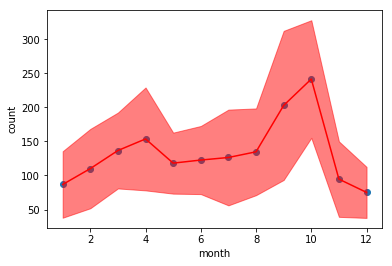

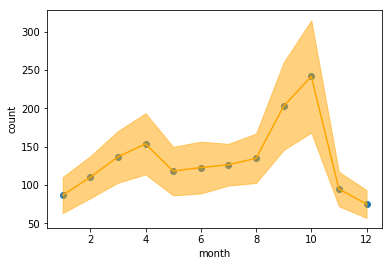

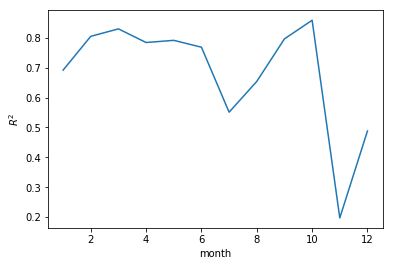

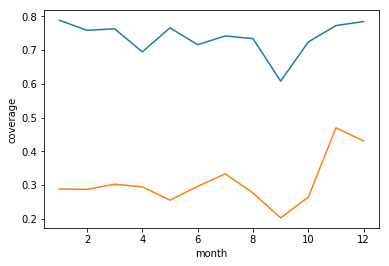

In [2233]:
prediction_profile(df_test,'month')

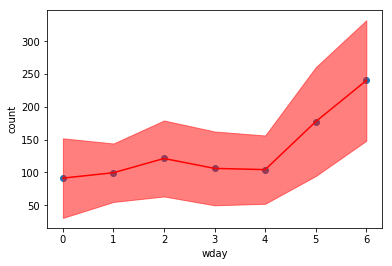

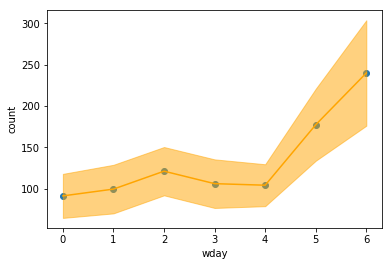

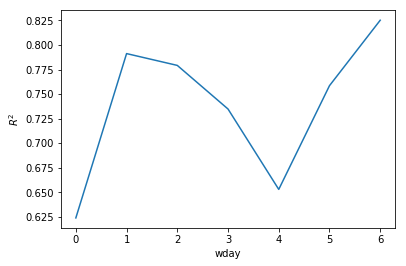

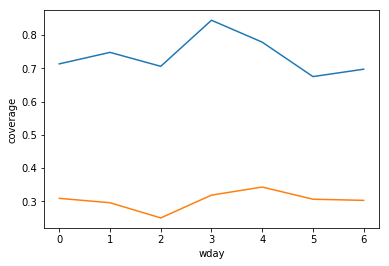

In [2234]:
prediction_profile(df_test,'wday')

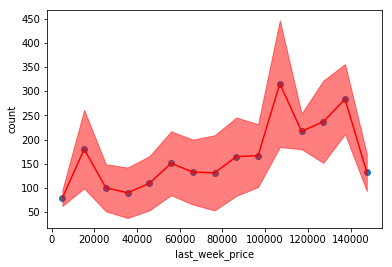

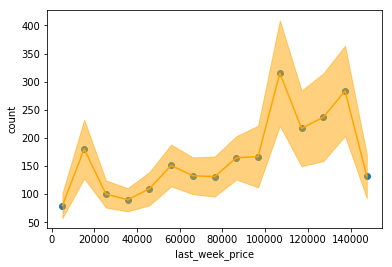

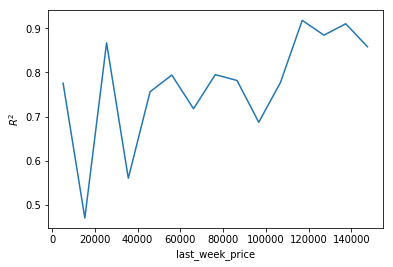

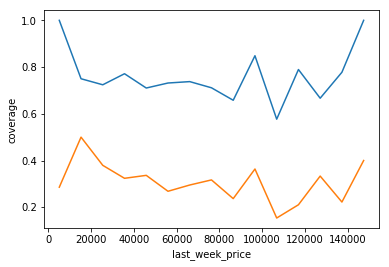

In [2235]:
prediction_profile(df_test,'last_week_price',bins=15)

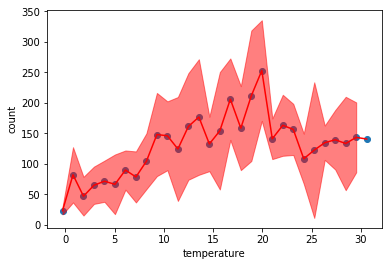

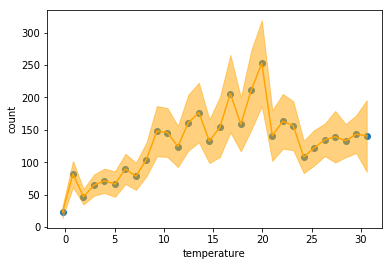

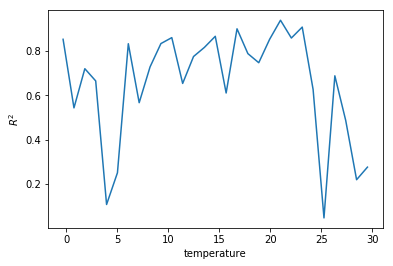

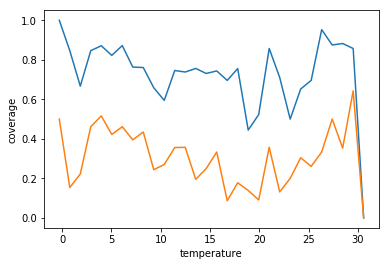

In [2236]:
prediction_profile(df_test,'temperature',bins=30)

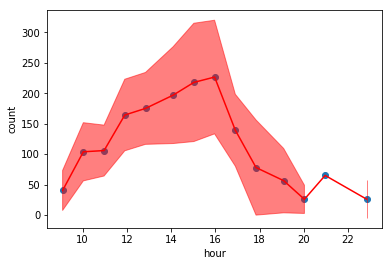

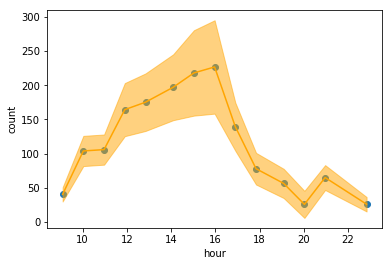

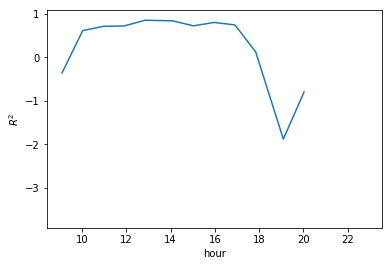

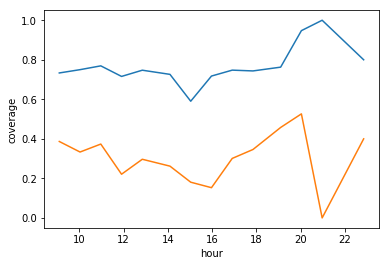

In [2237]:
prediction_profile(df_test,'hour',bins=48)#,range=[9,20])

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


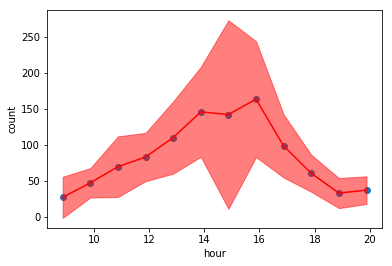

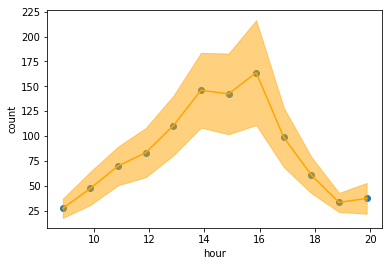

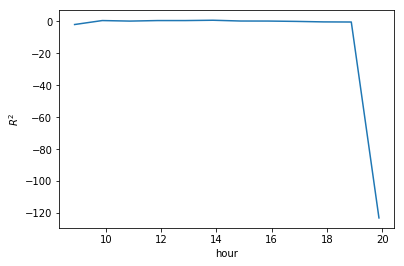

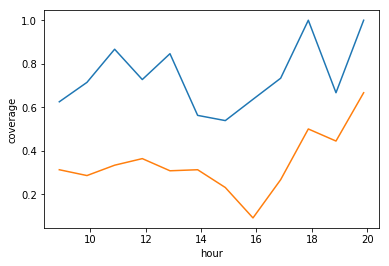

In [2238]:
prediction_profile(df_test[ df_test['wday'] == 0],'hour',bins=48, label='mon')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


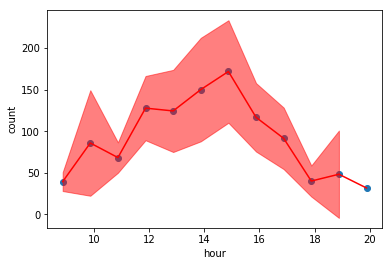

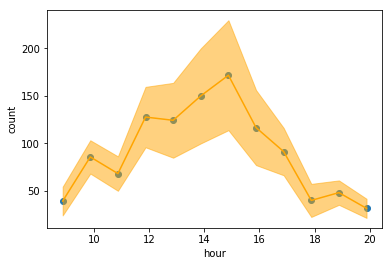

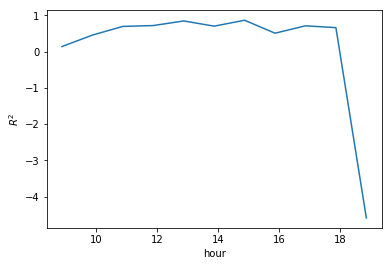

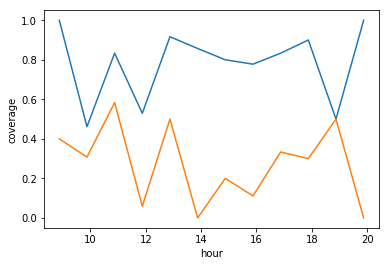

In [2239]:
prediction_profile(df_test[ df_test['wday'] == 1],'hour',bins=48, label='tue')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


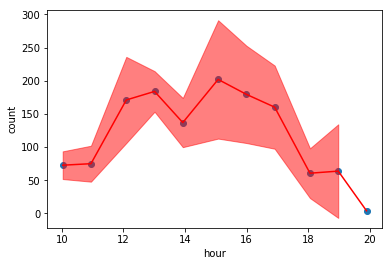

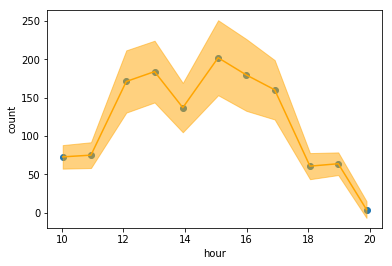

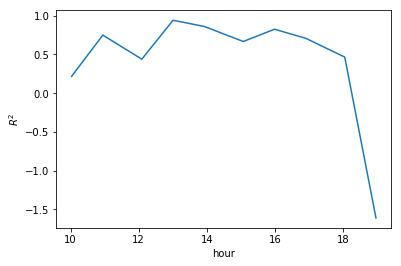

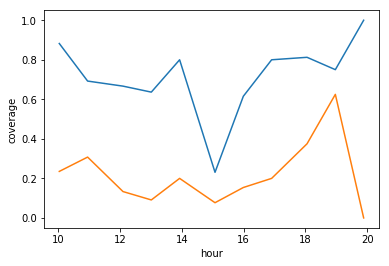

In [2240]:
prediction_profile(df_test[ df_test['wday'] == 2],'hour',bins=48, label='wed')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


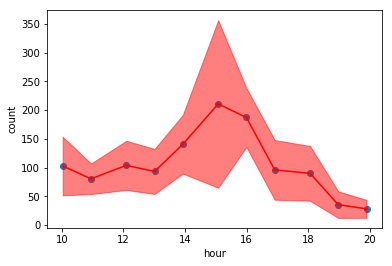

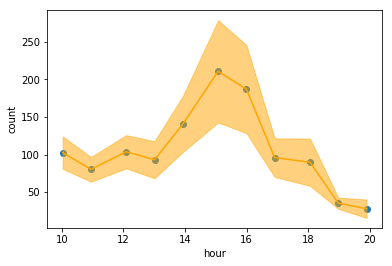

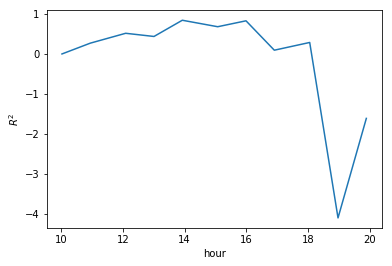

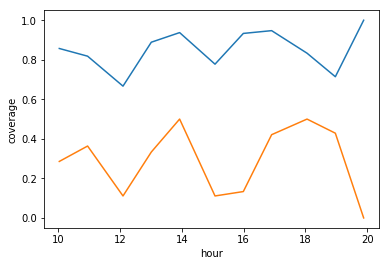

In [2241]:
prediction_profile(df_test[ df_test['wday'] == 3],'hour',bins=48, label='thu')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


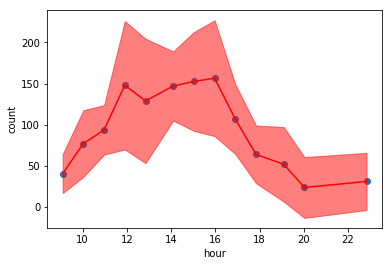

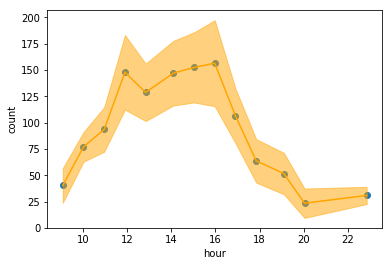

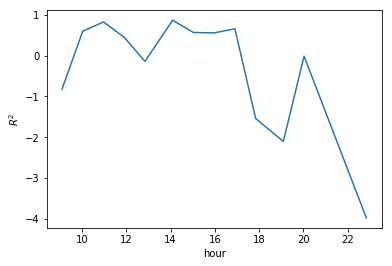

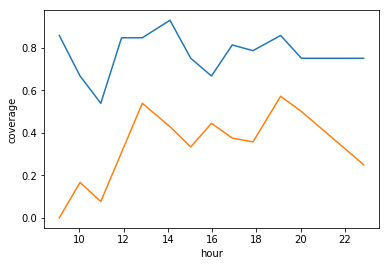

In [2242]:
prediction_profile(df_test[ df_test['wday'] == 4],'hour',bins=48, label='fri')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


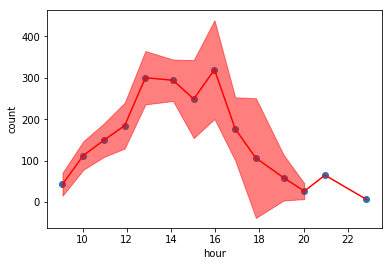

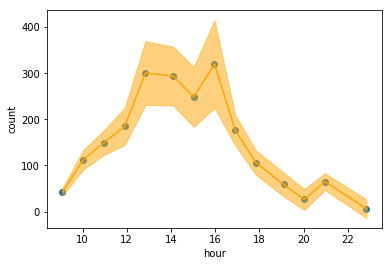

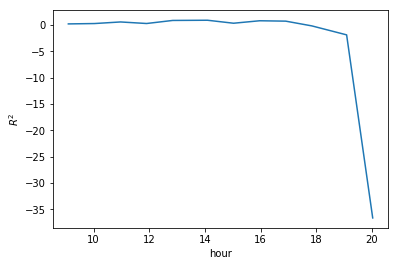

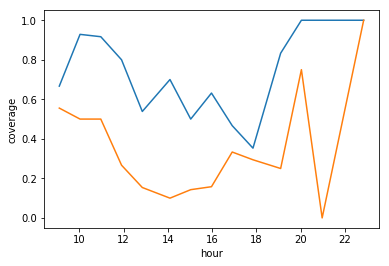

In [2243]:
prediction_profile(df_test[ df_test['wday'] == 5],'hour',bins=48, label='sat')

/home/musella/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


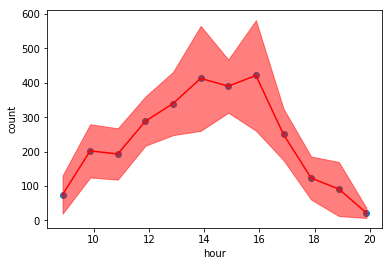

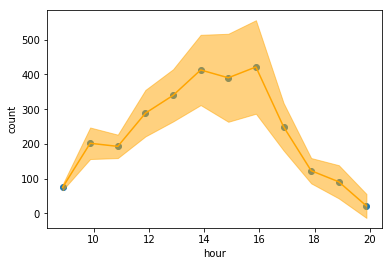

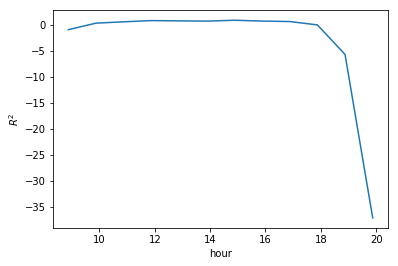

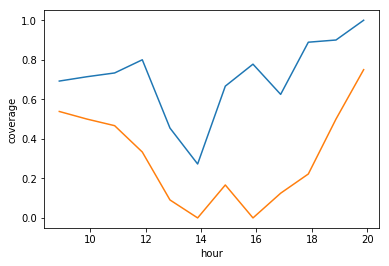

In [2244]:
prediction_profile(df_test[ df_test['wday'] == 6],'hour',bins=48, label='sun')

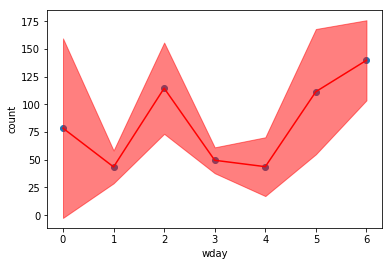

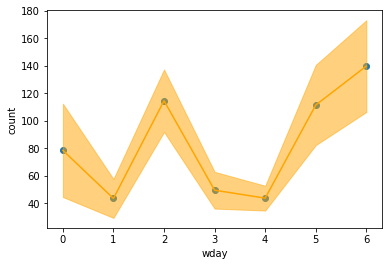

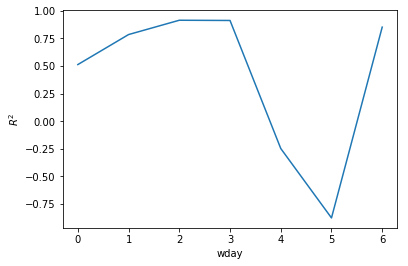

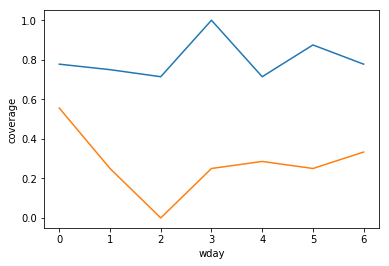

In [2245]:
prediction_profile(df_test[ df_test['month'] == 1],'wday', label='jan')

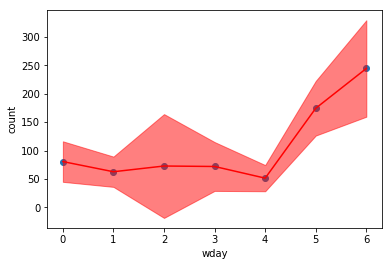

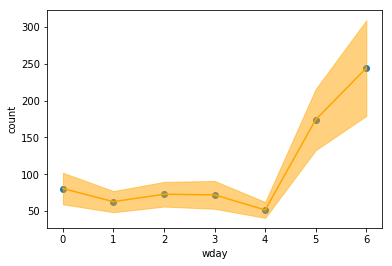

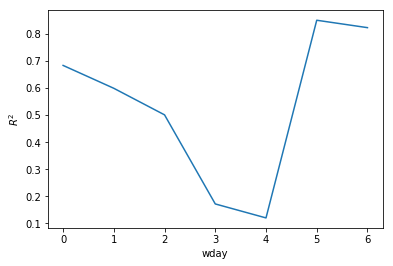

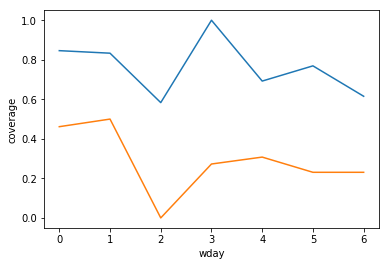

In [2246]:
prediction_profile(df_test[ df_test['month'] == 2],'wday', label='feb')

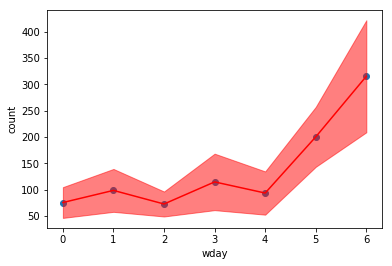

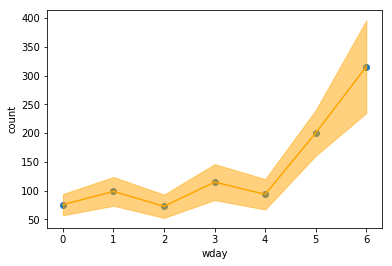

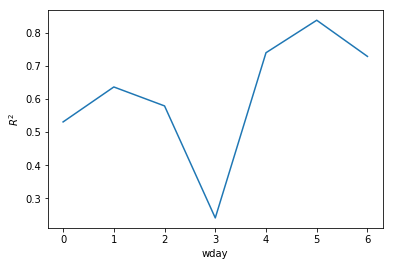

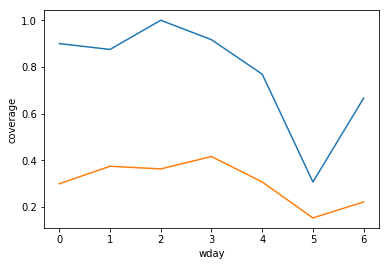

In [2247]:
prediction_profile(df_test[ df_test['month'] == 3],'wday', label='mar')

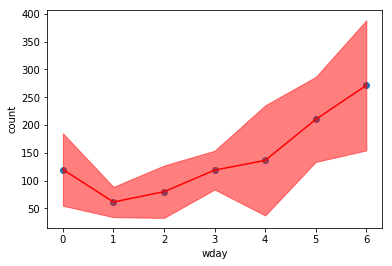

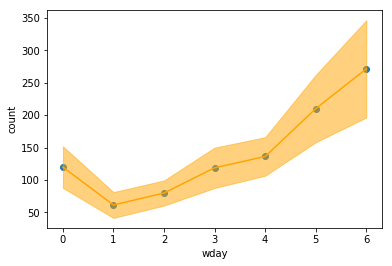

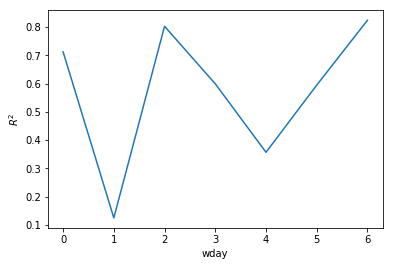

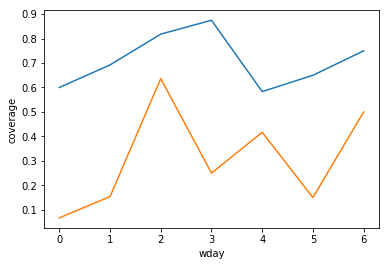

In [2248]:
prediction_profile(df_test[ df_test['month'] == 4],'wday', label='apr')

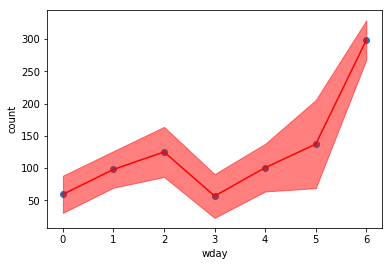

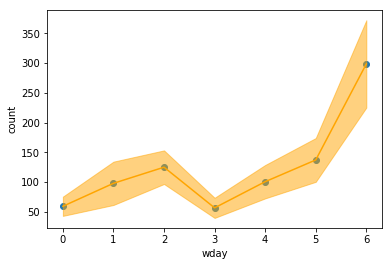

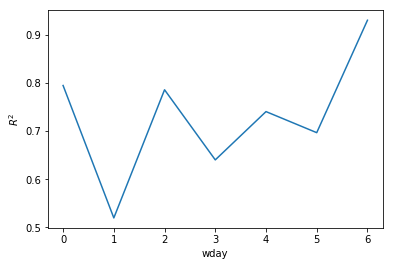

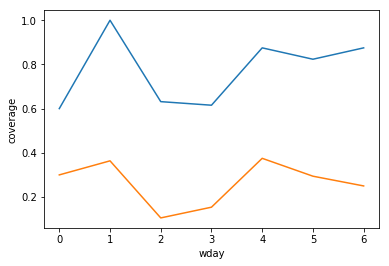

In [2249]:
prediction_profile(df_test[ df_test['month'] == 5],'wday', label='may')

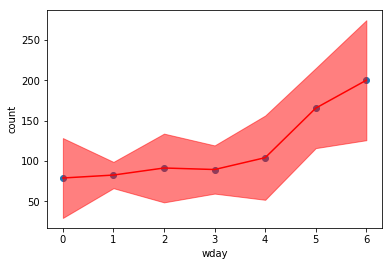

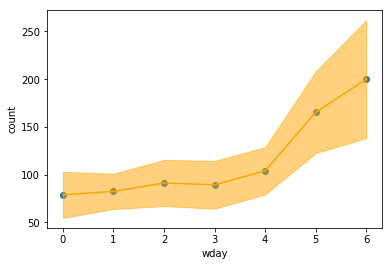

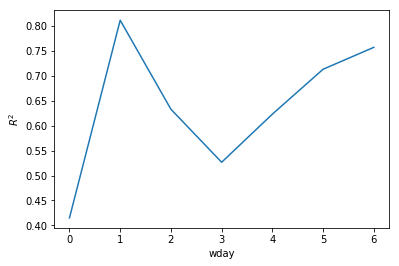

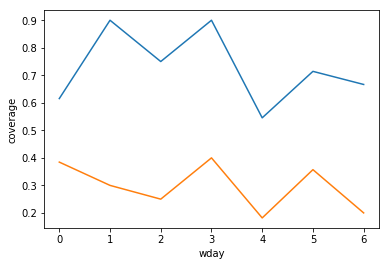

In [2250]:
prediction_profile(df_test[ df_test['month'] == 6],'wday', label='jun')

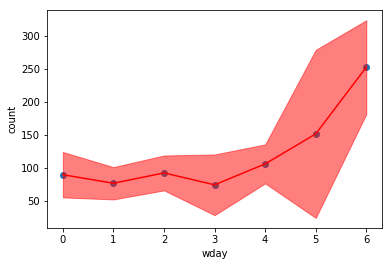

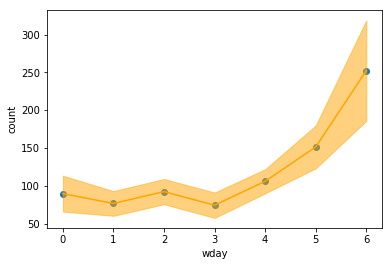

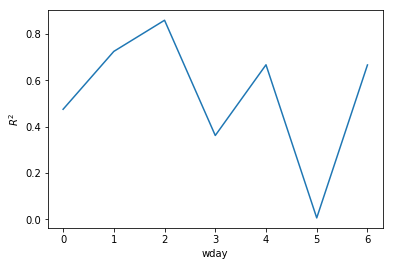

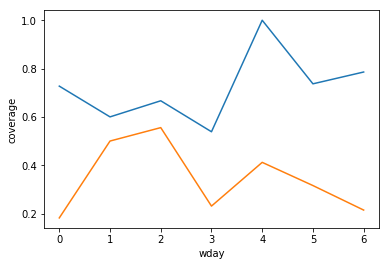

In [2251]:
prediction_profile(df_test[ df_test['month'] == 7],'wday', label='jul')

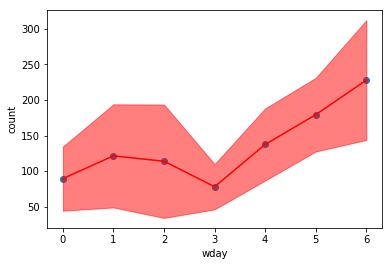

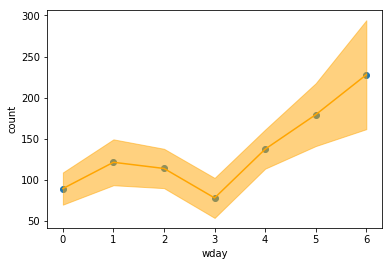

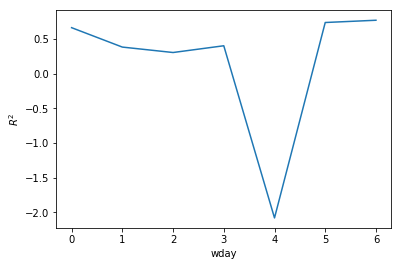

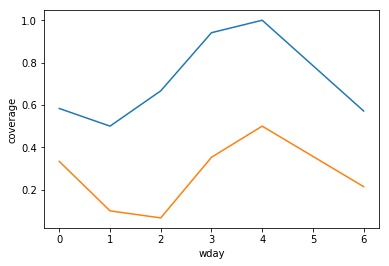

In [ ]:
prediction_profile(df_test[ df_test['month'] == 8],'wday', label='aug')

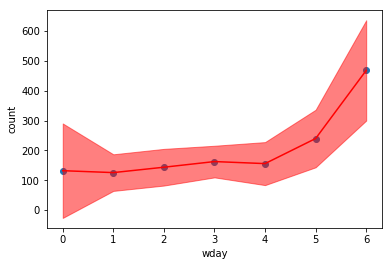

In [ ]:
prediction_profile(df_test[ df_test['month'] == 9],'wday', label='sep')

In [ ]:
prediction_profile(df_test[ df_test['month'] == 10],'wday', label='oct')

In [ ]:
prediction_profile(df_test[ df_test['month'] == 11],'wday', label='nov')

In [ ]:
prediction_profile(df_test[ df_test['month'] == 12],'wday', label='dec')